In [61]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from matplotlib.colors import to_rgba

In [62]:
# Global color mapping
colors = {
    -1: 'gray',
    -2: 'red',
    -3: 'green',
    -4: 'lightblue'
}

num_node = 16


def plot_timeline(ax, timeline, title, xticks, max_time):
    xticks = [float(f"{x:.2f}") for x in xticks]
    job_colors = {}
    has_submission = any('submission_time' in event for event in timeline)
    for event in timeline:
        nodes = sorted(event['allocated_resources'])
        groups = []
        while nodes:
            start = nodes[0]
            end = start
            while nodes and nodes[0] == end:
                end += 1
                nodes.pop(0)
            groups.append((start, end - start))

        for y, height in groups:
            if event['job_id'] in colors:
                color = colors[event['job_id']]
            else:
                if event['job_id'] not in job_colors:
                    job_colors[event['job_id']] = np.random.rand(3,)
                color = job_colors[event['job_id']]

            if event['terminated'] == True:
                color = (0.0, 0.0, 0.0)
            ax.broken_barh([(event['starting_time'], event['finish_time'] - event['starting_time'])],
                           (y, height), facecolors=color)

            if event['job_id'] > 0:
                ax.text((event['starting_time'] + event['finish_time']) / 2, y + height / 2,
                        str(event['job_id']), ha='center', va='center',
                        color='white' if np.mean(color) < 0.5 else 'black')

    for event in timeline:
        if event['job_id'] > 0:
            ax.plot(event['submission_time'], num_node+1, 'ro')
            ax.text(event['submission_time'], num_node+2,
                    str(event['job_id']), ha='center', va='center', color='red')

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, rotation=90, fontsize=8)
    ax.set_ylabel('Nodes')
    if has_submission:
        ax.set_yticks(range(num_node+2))
        ax.set_yticklabels(range(num_node+2))
    else:
        ax.set_yticks(range(num_node))
        ax.set_yticklabels(range(num_node))
    ax.set_xlim(0, max_time)
    ax.grid(True)
    ax.set_title(title)


def read_timeline(file_path):
    data = pd.read_csv(file_path)
    timeline = []
    has_submission = 'submission_time' in data.columns
    for _, row in data.iterrows():
        nodes = list(
            map(int, row.get('allocated_resources', row.get('nodes')).split()))
        entry = {
            'starting_time': float(row.get('starting_time', row.get('start_time'))),
            'finish_time': float(row['finish_time']),
            'allocated_resources': nodes,
            'type': row.get('type', row.get('state')),
            'job_id': int(row['job_id']),
            'terminated': row.get('terminated')
        }
        if has_submission:
            entry['submission_time'] = float(row['submission_time'])
        timeline.append(entry)
    return timeline

In [63]:
# CSV file path (NSV2 format)
node_log_path = "results/generated/node_log.csv"
# Output PNG file path
output_path = "plt/generated.png"

Gantt chart saved to: plt/generated.png


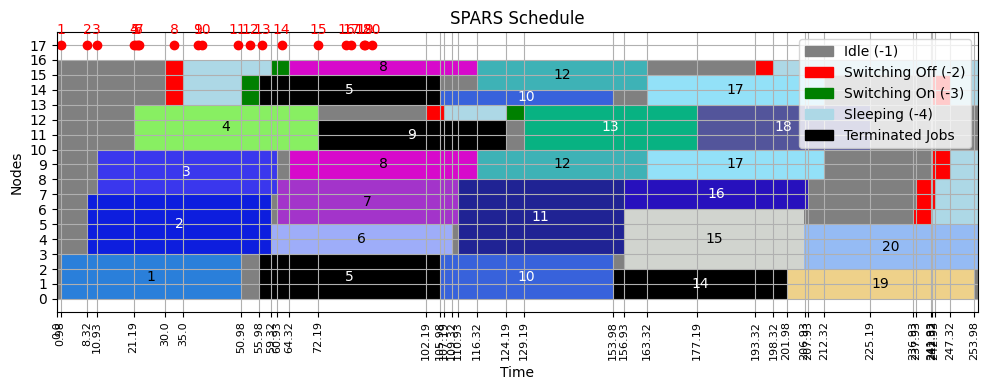

In [64]:
timeline_SPARS = read_timeline(node_log_path)

max_time = max([ev['finish_time'] for ev in timeline_SPARS])


num_plots = 1
fig, axes = plt.subplots(num_plots, 1, figsize=(10, 4 * num_plots))

if num_plots == 1:
    axes = [axes]

plot_timeline(axes[0], timeline_SPARS, "SPARS Schedule",
              sorted(set(e['starting_time'] for e in timeline_SPARS)
                     | set(e['finish_time'] for e in timeline_SPARS)),
              max_time)

idx = 1

axes[-1].set_xlabel("Time")


legend_patches = [
    mpatches.Patch(color='gray', label='Idle (-1)'),
    mpatches.Patch(color='red', label='Switching Off (-2)'),
    mpatches.Patch(color='green', label='Switching On (-3)'),
    mpatches.Patch(color='lightblue', label='Sleeping (-4)'),
    mpatches.Patch(color='black', label='Terminated Jobs')
]
axes[0].legend(handles=legend_patches, loc='upper right')

plt.tight_layout()

plt.savefig(output_path)
print(f"Gantt chart saved to: {output_path}")